## Preparations

Let us first load all the python libraries again

In [15]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.delphes import DelphesProcessor
from madminer.sampling import combine_and_shuffle
from madminer.utils.particle import MadMinerParticle

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

## 10. Run MadMiner at Detector Level

Let's first define the input file, the number of samples and *effective* number of samples

In [16]:
lhedatafile = 'data/madminer_lhedata.h5'
detectordatafile='data/madminer_detectordata.h5'
pythiadatafile='data/madminer_pythiadata.h5'

nsamples = 100000

### 10a) Run the Data Augmentation and Machine Learning part with Detetector Level Data

First, we once again augment the data and machine learning part again. Here  `n_samples` should be choosen similar to the effective number of events, which also depends on the cuts choosen earlier. 

In [3]:
sa = SampleAugmenter(detectordatafile, debug=False)

n_estimators = 5

for i in range(n_estimators):
    x, theta, t_xz = sa.extract_samples_train_local(
        theta=constant_benchmark_theta('sm'),
        n_samples=int(nsamples/2),
        folder='./data/samples_detector/',
        filename='train{}'.format(i)
    )

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_detector/',
    filename='test',
    switch_train_test_events=True
)

22:06  
22:06  ------------------------------------------------------------
22:06  |                                                          |
22:06  |  MadMiner v0.1.0                                         |
22:06  |                                                          |
22:06  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
22:06  |                                                          |
22:06  ------------------------------------------------------------
22:06  
22:06  Loading data from data/madminer_detectordata.h5
22:06  Found 2 parameters:
22:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
22:06     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
22:06  Found 6 benchmarks:
22:06     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
22:06     w: CWL2 = 20.00, CPWL2 = 0.00e+00
22:06     morphing_basis_vector_2: CWL2 = -3.26e+01, CPWL2 = -4.46e+01
22:06     morphing_basis_vector_3: CWL2 = 8.14, CPWL2 = -3.50e+

Next, we use the perform the ML part

In [4]:
ensemble = EnsembleForge(estimators=n_estimators)
ensemble.train_all(
    method='sally',
    x_filename=['data/samples_detector/x_train{}.npy'.format(i) for i in range(n_estimators)],
    t_xz0_filename=['data/samples_detector/t_xz_train{}.npy'.format(i) for i in range(n_estimators)]
)

ensemble.save('models/samples_detector')

22:06  Training 5 estimators in ensemble
22:06  Training estimator 1 / 5 in ensemble
22:06  Starting training
22:06    Method:                 sally
22:06    Training data: x at data/samples_detector/x_train0.npy
22:06                   t_xz (theta0) at  data/samples_detector/t_xz_train0.npy
22:06    Features:               all
22:06    Method:                 sally
22:06    Hidden layers:          (100, 100)
22:06    Activation function:    tanh
22:06    Batch size:             128
22:06    Trainer:                amsgrad
22:06    Epochs:                 50
22:06    Learning rate:          0.001 initially, decaying to 0.0001
22:06    Validation split:       None
22:06    Early stopping:         True
22:06    Scale inputs:           True
22:06    Shuffle labels          False
22:06    Regularization:         None
22:06  Loading training data
22:06  Found 50000 samples with 2 parameters and 21 observables
22:06  Rescaling inputs
22:06  Creating model for method sally
22:06  Training mod

### 10b) Run the Data Augmentation and Machine Learning part with Pythia Level Data

Now we repeat the same procedure, but with the pythia level data

In [5]:
sa = SampleAugmenter(pythiadatafile, debug=False)

n_estimators = 5

for i in range(n_estimators):
    x, theta, t_xz = sa.extract_samples_train_local(
        theta=constant_benchmark_theta('sm'),
        n_samples=int(nsamples/2),
        folder='./data/samples_pythia/',
        filename='train{}'.format(i)
    )

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_pythia/',
    filename='test',
    switch_train_test_events=True
)

22:10  Loading data from data/madminer_pythiadata.h5
22:10  Found 2 parameters:
22:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
22:10     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
22:10  Found 6 benchmarks:
22:10     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
22:10     w: CWL2 = 20.00, CPWL2 = 0.00e+00
22:10     morphing_basis_vector_2: CWL2 = -3.26e+01, CPWL2 = -4.46e+01
22:10     morphing_basis_vector_3: CWL2 = 8.14, CPWL2 = -3.50e+01
22:10     morphing_basis_vector_4: CWL2 = -3.51e+01, CPWL2 = 32.41
22:10     morphing_basis_vector_5: CWL2 = 5.86, CPWL2 = 39.09
22:10  Found 21 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_a, e_l, e_a, pt_l, pt_v, pt_a, eta_l, eta_a, dphi_lv, dphi_la, dphi_va, m_la, mt, phi_resurrection
22:10  Found 77511 events
22:10  Found morphing setup with 6 components
22:10  Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark

In [6]:
ensemble = EnsembleForge(estimators=n_estimators)
ensemble.train_all(
    method='sally',
    x_filename=['data/samples_pythia/x_train{}.npy'.format(i) for i in range(n_estimators)],
    t_xz0_filename=['data/samples_pythia/t_xz_train{}.npy'.format(i) for i in range(n_estimators)]
)

ensemble.save('models/samples_pythia')

22:10  Training 5 estimators in ensemble
22:10  Training estimator 1 / 5 in ensemble
22:10  Starting training
22:10    Method:                 sally
22:10    Training data: x at data/samples_pythia/x_train0.npy
22:10                   t_xz (theta0) at  data/samples_pythia/t_xz_train0.npy
22:10    Features:               all
22:10    Method:                 sally
22:10    Hidden layers:          (100, 100)
22:10    Activation function:    tanh
22:10    Batch size:             128
22:10    Trainer:                amsgrad
22:10    Epochs:                 50
22:10    Learning rate:          0.001 initially, decaying to 0.0001
22:10    Validation split:       None
22:10    Early stopping:         True
22:10    Scale inputs:           True
22:10    Shuffle labels          False
22:10    Regularization:         None
22:10  Loading training data
22:10  Found 50000 samples with 2 parameters and 21 observables
22:10  Rescaling inputs
22:10  Creating model for method sally
22:10  Training model
2

### 10c) Obtain the Fisher Info

Now let's evaluate the Fisher Info again

In [20]:
fisher_parton = FisherInformation(lhedatafile, debug=False)

fi_ml_mean, fi_ml_covariance = fisher_parton.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_ensemble',
    unweighted_x_sample_file='data/samples_ensemble/x_test.npy',
    luminosity=300*1000./nsamples
)

fi_metonly_mean, fi_metonly_covariance = fisher_parton.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_metonly',
    unweighted_x_sample_file='data/samples_ensemble/x_test.npy',
    luminosity=300*1000./nsamples
)

fi_truth_mean, fi_truth_covariance = fisher_parton.calculate_fisher_information_full_truth(
    theta=[0.,0.],
    luminosity=300*1000./nsamples
)

fisher_detector = FisherInformation(detectordatafile, debug=False)

fi_detector_mean, fi_detector_covariance = fisher_detector.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_detector',
    unweighted_x_sample_file='data/samples_detector/x_test.npy',
    luminosity=300*1000.#/nsamples
)

fisher_pythia = FisherInformation(pythiadatafile, debug=False)

fi_pythia_mean, fi_pythia_covariance = fisher_pythia.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_pythia',
    unweighted_x_sample_file='data/samples_pythia/x_test.npy',
    luminosity=300*1000.#/nsamples
)

22:38  Loading data from data/madminer_lhedata.h5
22:38  Found 2 parameters:
22:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
22:38     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
22:38  Found 6 benchmarks:
22:38     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
22:38     w: CWL2 = 20.00, CPWL2 = 0.00e+00
22:38     morphing_basis_vector_2: CWL2 = -3.26e+01, CPWL2 = -4.46e+01
22:38     morphing_basis_vector_3: CWL2 = 8.14, CPWL2 = -3.50e+01
22:38     morphing_basis_vector_4: CWL2 = -3.51e+01, CPWL2 = 32.41
22:38     morphing_basis_vector_5: CWL2 = 5.86, CPWL2 = 39.09
22:38  Found 26 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, pt_l, pt_v, pt_a, eta_l, eta_v, eta_a, dphi_lv, dphi_la, dphi_va, m_lv, m_lva, m_la, mtrans, phi_resurrection
22:38  Found 100000 events
22:38  Found morphing setup with 6 components
22:38  Evaluating rate Fisher information
22:38  Found ensemble with 5 estimators an

And let's plot the result

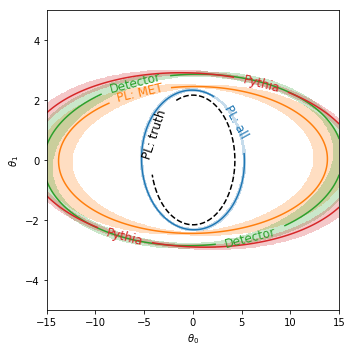

In [21]:
_ = plot_fisher_information_contours_2d(
    [fi_ml_mean, fi_metonly_mean, fi_detector_mean,fi_pythia_mean,fi_truth_mean ],
    [fi_ml_covariance, fi_metonly_covariance,fi_detector_covariance, fi_pythia_covariance,fi_truth_covariance],
    colors=[u'C0',u'C1',u'C2',u'C3',"black"],
    linestyles=["solid","solid","solid","solid","dashed"],
    inline_labels=["PL: all","PL: MET","Detector","Pythia","PL: truth"],
    xrange=(-15,15),
    yrange=(-5,5)
)